# Load data

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

dataset_match = {
    "fbirn": "FBIRN ICA",
    "fbirn_roi": "FBIRN Schaefer 200 ROI",
    "bsnip": "BSNIP ICA",
    "cobre": "COBRE ICA",

    "abide": "ABIDE1 ICA 569 subjects",
    "abide_869": "ABIDE1 ICA",
    "abide_roi": "ABIDE1 Schaefer 200 ROI",

    "oasis": "OASIS3 ICA",
    "adni": "ADNI ICA",

    "hcp": "HCP ICA",
    "hcp_roi": "HCP Schaefer 200 ROI",
    "hcp_non_mni": "HCP Deskian/Killiany ROI",

    "ukb": "UK Biobank (Sex) ICA",
    "ukb_age_bins": "UK Biobank (Age-Sex) ICA",

    "time_fbirn": "FBIRN (Time Direction) ICA",

    "fbirn_bsnip": "FxB",
    "fbirn_cobre": "FxC",

    "bsnip_fbirn": "BxF",
    "bsnip_cobre": "BxC",

    "cobre_fbirn": "CxF",
    "cobre_bsnip": "CxB",

    "oasis_adni": "OxA",
    "adni_oasis": "AxO",
}

model_match = {
    "mlp": "MLP",
    "lstm": "LSTM",
    "mean_lstm": r"$\mu$LSTM",
    "transformer": "Transformer",
    "mean_transformer": r"$\mu$Transformer",
    "milc": "MILC",
    "stdim": "ST-DIM",
    "dice": "DICE",
    "bnt": "BNT",
    "fbnetgen": "FBNetGen",
    "brainnetcnn": "BrainNetCNN",
    "lr": "LR",
}

def fix_run(run, dataset):
    for _, row in run.history().iterrows():
        if f"{dataset}score" in row and f"{dataset}accuracy" in row and "training_time" in row and f"{dataset}average_time" in row:
            auc = row[f"{dataset}score"]
            acc = row[f"{dataset}accuracy"]
            train_t = row["training_time"]
            inf_t= row[f"{dataset}average_time"]
            break
    
    run.summary[f"{dataset}score"] = auc
    run.summary[f"{dataset}accuracy"] = acc
    run.summary["training_time"] = train_t
    run.summary[f"{dataset}average_time"] = inf_t

    run.update()

    return auc, acc, train_t, inf_t

def load_run(proj_name, dataset):
    if dataset is not None:
        dataset += "_"
    else:
        dataset += "test_"

    api = wandb.Api(timeout=19)
    # Project is specified by <entity/project-name>
    runs = api.runs(f"pavalipopov/{proj_name}")

    summary_list = []
    runs_list = []
    for i, run in enumerate(runs): 
        # print(f"Run {i}")
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)
        runs_list.append(run)


    AUC_score = []
    accuracy = []
    train_time = []
    inference_time = []
    params = []
    shuffling = []

    for i, summary in enumerate(summary_list):
        if f"{dataset}score" in summary and f"{dataset}accuracy" in summary and "training_time" in summary and f"{dataset}average_time" in summary:
            AUC_score.append(summary[f"{dataset}score"])
            accuracy.append(summary[f"{dataset}accuracy"])
            train_time.append(summary["training_time"])
            inference_time.append(summary[f"{dataset}average_time"])
        else:
            print(f"Run {i} summary is broken, fixing it")
            auc, acc, train_t, inf_t = fix_run(runs_list[i], dataset)
            AUC_score.append(auc)
            accuracy.append(acc)
            train_time.append(train_t)
            inference_time.append(inf_t)

        if "params" in summary:
            params.append(summary["params"])
        else:
            params.append(None)

        if "general.permute" in summary:
            if summary["general.permute"] is False:
                shuffling.append("None")
            else:
                shuffling.append(summary["general.permute"])
        else:
            shuffling.append("None")
    
    return AUC_score, accuracy, train_time, inference_time, params, shuffling

def load_metrics(paths_dict, ds_dict, model_dict):
    data_list = []

    for model_name in paths_dict:
        print(model_name)
        for dataset_name in paths_dict[model_name]:
            print("\t ", dataset_name)
            
            if len(paths_dict[model_name][dataset_name]) == 2:
                path = paths_dict[model_name][dataset_name][0]
                dataset = paths_dict[model_name][dataset_name][1]
            elif len(paths_dict[model_name][dataset_name]) == 1:
                path = paths_dict[model_name][dataset_name][0]
                dataset = "test"
            else:
                raise NotImplementedError()

            print("\t\t sub_dataset:", dataset)

            AUC_score, accuracy, train_time, inference_time, params, shuffling = load_run(path, dataset)
            
            if dataset != "test":
                dataset = dataset_name + "_" + dataset
            else:
                dataset = dataset_name
            length = len(AUC_score)

            data_list.append(
                pd.DataFrame(
                    {
                        "Model": [model_dict[model_name]]*length,
                        "Dataset": [ds_dict[dataset]]*length,
                        "AUROC": AUC_score,
                        "Accuracy": accuracy,
                        "Train time": train_time,
                        "Inference time": inference_time,
                        "Trainable params": params,
                        "Shuffling": shuffling,
                    }
                )
            )
    
    return pd.concat(data_list)

In [12]:
projects = {
    "mlp": {
        "hcp": ("yesmni-exp-mlp-hcp", ),
        "hcp_non_mni": ("nonmni-exp-mlp-hcp_non_mni", ),
    },
    "lstm": {
        "hcp": ("yesmni-exp-lstm-hcp", ),
        "hcp_non_mni": ("nonmni-exp-lstm-hcp_non_mni", ),
    },
    "mean_lstm": {
        "hcp": ("yesmni-exp-mean_lstm-hcp", ),
        "hcp_non_mni": ("nonmni-exp-mean_lstm-hcp_non_mni", ),
    },
    "transformer": {
        "hcp": ("yesmni-exp-transformer-hcp", ),
        "hcp_non_mni": ("nonmni-exp-transformer-hcp_non_mni", ),
    },
    "mean_transformer": {
        "hcp": ("yesmni-exp-mean_transformer-hcp", ),
        "hcp_non_mni": ("nonmni-exp-mean_transformer-hcp_non_mni", ),
    },
}

In [13]:
data = load_metrics(projects, dataset_match, model_match)

mlp
	  hcp
		 sub_dataset: test
	  hcp_non_mni
		 sub_dataset: test
lstm
	  hcp
		 sub_dataset: test
	  hcp_non_mni
		 sub_dataset: test
mean_lstm
	  hcp
		 sub_dataset: test
	  hcp_non_mni
		 sub_dataset: test
transformer
	  hcp
		 sub_dataset: test
	  hcp_non_mni
		 sub_dataset: test
mean_transformer
	  hcp
		 sub_dataset: test
	  hcp_non_mni
		 sub_dataset: test


In [14]:
data

,Model,Dataset,AUROC,Accuracy,Train time,Inference time,Trainable params,Shuffling
0,MLP,HCP ICA,0.895396,0.801205,23.009837,0.000248,6372,None
1,MLP,HCP ICA,0.887092,0.789157,19.284591,0.000262,6372,None
2,MLP,HCP ICA,0.924534,0.861446,33.409198,0.000248,6372,None
3,MLP,HCP ICA,0.914773,0.819277,27.494873,0.000298,6372,None
4,MLP,HCP ICA,0.911568,0.819277,25.178708,0.000248,6372,None
...,...,...,...,...,...,...,...,...
45,$\mu$Transformer,HCP Deskian/Killiany ROI,0.687285,0.610465,85.536299,0.001268,1353437,None
46,$\mu$Transformer,HCP Deskian/Killiany ROI,0.823643,0.709302,147.592736,0.001255,1353437,None
47,$\mu$Transformer,HCP Deskian/Killiany ROI,0.765361,0.703488,125.988321,0.001255,1353437,None
48,$\mu$Transformer,HCP Deskian/Killiany ROI,0.827491,0.773256,179.590638,0.001275,1353437,None


# Plot data

## All results

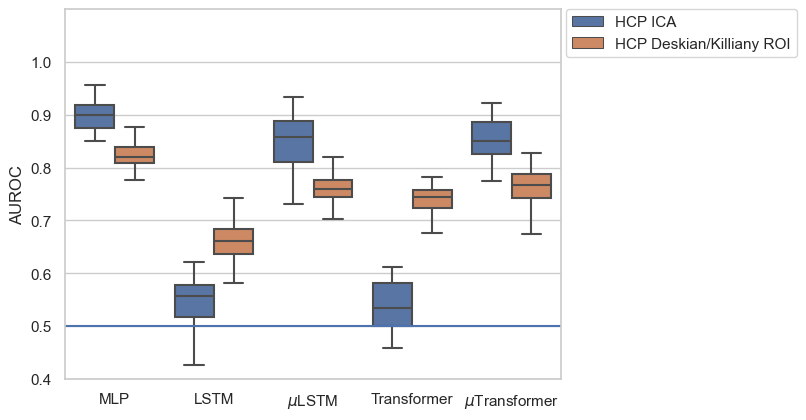

In [19]:
import matplotlib.ticker as ticker
from statannot import add_stat_annotation

sns.reset_orig()
sns.set_theme(
    style="whitegrid", 
    font_scale = 1,
)


palette = {
    "MLP": "C0",
    'LSTM': "C1",
    r'$\mu$LSTM': "C2",
    'Transformer': "C3",
    r'$\mu$Transformer': "C4",
    "MILC": "C5",
    "ST-DIM": "C6",
    "DICE": "C7",
    "BNT": "C8",
    "FBNetGen": "C9",
    "BrainNetCNN": "C10",
    "LR": "C11",
}

ax = sns.boxplot(
    x="Model", 
    y="AUROC",
    hue="Dataset",
    data=data,
    # palette=palette,
    showfliers = False
)

ax.set(xlabel=None)
ax.axhline(0.5)

plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left', borderaxespad=0)
# plt.title(label="ICA - Neuromark")

plt.ylim(0.4, 1.1)
# ax.set_xlim(xmin=-0.5, xmax=8.5)

# ax.patches[11].set_hatch("///")
# ax.patches[13].set_hatch("///")
# for i, box in enumerate(ax.patches):
#     # Set a different hatch for each bar
#     if i > 7:
#         if i % 9 == 5 or i % 9 == 6 or i % 9 == 7 or i % 9 == 8:
#             box.set_hatch("///")

# ax.legend_.legendHandles[5].set_hatch("///")
# ax.legend_.legendHandles[6].set_hatch("///")
# ax.legend_.legendHandles[7].set_hatch("///")
# ax.legend_.legendHandles[8].set_hatch("///")

# sns.set_theme(
#     font_scale = 1,
# )

# add_stat_annotation(ax, data=ica_data, x="Dataset", y="AUC", hue="Model",
#                     box_pairs=[
#                         (("FBIRN", "MLP"), ("FBIRN", "BNT")), (("FBIRN", "LR"), ("FBIRN", "BNT")), (("FBIRN", "LR"), ("FBIRN", "MLP")),
#                         (("BSNIP", "MLP"), ("BSNIP", "BNT")), (("BSNIP", "LR"), ("BSNIP", "BNT")), (("BSNIP", "LR"), ("BSNIP", "MLP")),
#                         (("COBRE", "MLP"), ("COBRE", "BNT")), (("COBRE", "LR"), ("COBRE", "BNT")), (("COBRE", "LR"), ("COBRE", "MLP")),
#                         (("ABIDE1", "MLP"), ("ABIDE1", "BNT")), (("ABIDE1", "LR"), ("ABIDE1", "BNT")), (("ABIDE1", "LR"), ("ABIDE1", "MLP")),
#                         (("OASIS3", "MLP"), ("OASIS3", "BNT")), (("OASIS3", "LR"), ("OASIS3", "BNT")), (("OASIS3", "LR"), ("OASIS3", "MLP")),
#                         (("ADNI", "MLP"), ("ADNI", "BNT")), (("ADNI", "LR"), ("ADNI", "BNT")), (("ADNI", "LR"), ("ADNI", "MLP")),
#                         (("HCP", "MLP"), ("HCP", "BNT")), (("HCP", "LR"), ("HCP", "BNT")), (("HCP", "LR"), ("HCP", "MLP")),
#                         (("UKB-S", "MLP"), ("UKB-S", "BNT")), (("UKB-S", "LR"), ("UKB-S", "BNT")), (("UKB-S", "LR"), ("UKB-S", "MLP")),
#                         (("UKB-SA", "MLP"), ("UKB-SA", "BNT")), (("UKB-SA", "LR"), ("UKB-SA", "BNT")), (("UKB-SA", "LR"), ("UKB-SA", "MLP")),
#                     ],
#                     test='Wilcoxon', text_format='star', loc='inside', verbose=1, text_offset=-4, 
#                     pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
#                     line_offset=0.01, line_offset_to_box=0.01, line_height=0.01, fontsize=24)

plt.show()
# plt.savefig(
#     "0.svg",
#     format="svg",
#     # dpi=300,
#     bbox_inches='tight',
# )
plt.close()

## Shuffling results

p-value annotation legend:
°: 5.00e-02 < p <= 1.00e+00
*: p <= 5.00e-02

p-value annotation legend:
°: 5.00e-02 < p <= 1.00e+00
*: p <= 5.00e-02



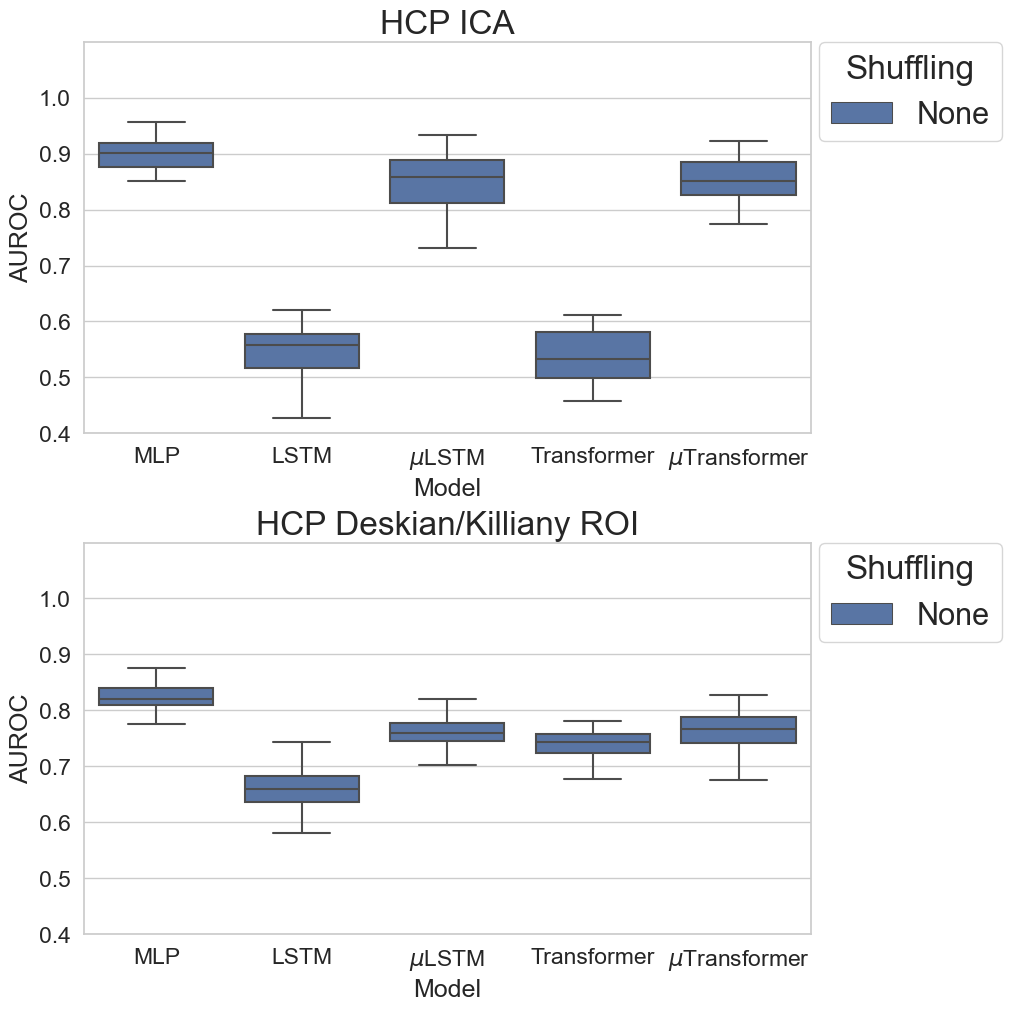

In [15]:
import matplotlib.ticker as ticker
from statannot import add_stat_annotation

sns.reset_orig()
sns.set_theme(
    style="whitegrid", 
    font_scale = 1.5,
)

# datasets = ["FBIRN ICA", "FBIRN Schaefer 200", "BSNIP ICA", "COBRE ICA", "ABIDE1 ICA", "OASIS3 ICA", "ADNI ICA", "HCP ICA", "F-time"]
datasets = ["HCP ICA", "HCP Deskian/Killiany ROI"]

fig = plt.figure(constrained_layout=True, figsize=(10, 5*len(datasets)))
# fig = plt.figure(constrained_layout=True)
axs = fig.subplots(len(datasets), 1)

sns.set_theme(
    style="whitegrid", 
    font_scale = 2, 
    rc={'figure.figsize':(16,5)}
)

for i, dataset in enumerate(datasets):
    plot_data = data.query(
        "Dataset == @dataset")

    sns.boxplot(
        x="Model", 
        y="AUROC",
        hue="Shuffling",
        data=plot_data,
        showfliers = False,
        ax = axs[i]
    )

    # subfigs[i].axhline(0.5)
    axs[i].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    axs[i].legend(bbox_to_anchor=(1.01, 1.0), loc='upper left', borderaxespad=0, title="Shuffling")

    axs[i].set_title(dataset)

    axs[i].set_ylim(0.4, 1.1)

    try:
        add_stat_annotation(axs[i], data=plot_data, x="Model", y="AUC", hue="Permuted",
                box_pairs=[
                    (("MLP", True), ("MLP", False)),
                    (("LSTM", True), ("LSTM", False)),
                    (("Mean LSTM", True), ("Mean LSTM", False)),
                    (("TF", True), ("TF", False)),
                    (("Mean TF", True), ("Mean TF", False)),
                ],
                test='Wilcoxon', text_format='star', loc='inside', verbose=1, text_offset=-4, 
                pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
                line_offset=0.01, line_offset_to_box=0.02, line_height=0.01, fontsize=13)
    except ValueError:
        pass

plt.show()
# plt.savefig(
#     "./plots/shiffling.png",
#     format="png",
#     dpi=300,
#     bbox_inches='tight',
#     transparent=False,
# )
plt.close()